In [1]:
#Importação de pacotes
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import joblib # Utilizado para salvar o modelo preditivo
from sklearn.preprocessing import LabelEncoder #Utilizada para fazer o OneHotEncoding
from sklearn.metrics import mean_squared_error,precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from imblearn import under_sampling, over_sampling #Utilizada para fazer o balanceamento de dados
from imblearn.over_sampling import SMOTE #Utilizada para fazer o balanceamento de dados
from sklearn.preprocessing import MinMaxScaler #Utilizada para fazer a padronização dos dados
from sklearn.metrics import r2_score # Utilizado para medir a acuracia do modelo preditivo
import pymssql as sql #conexão SQL
import pyodbc
from sklearn.model_selection import KFold, cross_val_score, train_test_split



warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pd.options.display.float_format = '{:.2f}'.format

In [2]:
# Cria a conexão com o SQL Server passando os parametros (Servidor, Usuário, Senha, Database)
conexao = sql.connect('DESKTOP-24MCU0H\SQL','blu_trostdo','123456','MODELOS_PREDITIVOS')

#conexao = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=localhost;DATABASE=MODELOS PREDITIVOS;UID=sa;PWD=123456')

# Chama a consulta ao banco de dados passando os parametros da conexão criada
df_original = pd.read_sql_query('select * from EXTRACAO_DADOS_SISTEMA', conexao)

# Fecha conexão com banco de dados
conexao.close()

df_original.shape

df_original.head(10)

NUMERO_CONTRATO DATA_ASSINATURA_CONTRATO TIPO_FINANCIAMENTO  TAXA_AO_ANO  \
0            41637               2012-03-23        IMOBILIARIO         15.0   
1            67958               2012-01-24        IMOBILIARIO         15.0   
2            68502               2014-05-23        IMOBILIARIO         18.0   
3            68731               2015-10-23        IMOBILIARIO         15.0   
4            68996               2017-01-24        IMOBILIARIO         17.0   
5            94496               2016-02-16        IMOBILIARIO         17.0   
6            94515               2016-02-16        IMOBILIARIO         17.0   
7            94532               2016-03-11        IMOBILIARIO         17.0   
8            94583               2017-04-11        IMOBILIARIO         20.0   
9            94609               2015-10-14        IMOBILIARIO         17.0   

   PZ_FINANCIAMENTO        CIDADE_CLIENTE ESTADO_CLIENTE  \
0               180             FORTALEZA             CE   
1               200             SAO PAULO             SP   
2               200             SAO PAULO             SP   
3               200             SAO PAULO             SP   
4               200             SAO PAULO             SP   
5                72             SAO PAULO             SP   
6                72                CUIABA             MT   
7                72             SAO PAULO             SP   
8                72             SAO PAULO             SP   
9                72  APARECIDA DE GOIANIA             GO   

   RENDA_MENSAL_CLIENTE  QT_PC_ATRASO  QT_DIAS_PRIM_PC_ATRASO  \
0                4800.0             0                       0   
1                6800.0             0                       0   
2                6800.0             0                       0   
3                6800.0             0                       0   
4                6800.0             0                       0   
5                9800.0             0                       0   
6                9800.0             0                       0   
7                9800.0             0                       0   
8                9800.0             0                       0   
9                9800.0             0                       0   

   QT_TOTAL_PC_PAGAS  VL_TOTAL_PC_PAGAS  QT_PC_PAGA_EM_DIA  \
0                 97          120078.00                 72   
1                103          156759.47                 42   
2                 98          277125.05                 83   
3                 87          351395.19                 66   
4                 71          344249.83                 57   
5                 33           29500.80                 29   
6                 45           22235.92                 16   
7                 36           22781.74                 34   
8                 43           19421.77                  5   
9                 25           10506.77                 21   

   QT_DIAS_MIN_ATRASO  QT_DIAS_MAX_ATRASO  QT_DIAS_MEDIA_ATRASO  \
0                   3                 506                   152   
1                   1                 349                    93   
2                   1                 151                    39   
3                   1                3797                   206   
4                   1                  36                    10   
5                  20                  34                    25   
6                   3                 129                    56   
7                   3                   3                     3   
8                   7                 101                    44   
9                   3                  18                     8   

   VALOR_FINANCIAMENTO  VALOR_PARCELA  IDADE_DATA_ASSINATURA_CONTRATO  \
0              73767.0         471.29                            70.0   
1             323251.0        1858.69                            28.0   
2             529419.0        3123.57                            60.0   
3             499753.0        2873.58      

In [3]:
df_original.isnull().sum()

#Analisando estes dados missing verificamos que na tabela 'VL_TOTAL_PC_PAGAS 'possui 4 dados nulos e 'IDADE_DATA_ASSINATURA_CONTRATO'
#possui 1 dado nulo. 

NUMERO_CONTRATO                   0
DATA_ASSINATURA_CONTRATO          0
TIPO_FINANCIAMENTO                0
TAXA_AO_ANO                       0
PZ_FINANCIAMENTO                  0
CIDADE_CLIENTE                    0
ESTADO_CLIENTE                    0
RENDA_MENSAL_CLIENTE              0
QT_PC_ATRASO                      0
QT_DIAS_PRIM_PC_ATRASO            0
QT_TOTAL_PC_PAGAS                 0
VL_TOTAL_PC_PAGAS                 4
QT_PC_PAGA_EM_DIA                 0
QT_DIAS_MIN_ATRASO                0
QT_DIAS_MAX_ATRASO                0
QT_DIAS_MEDIA_ATRASO              0
VALOR_FINANCIAMENTO               0
VALOR_PARCELA                     0
IDADE_DATA_ASSINATURA_CONTRATO    1
INADIMPLENTE_COBRANCA             0
dtype: int64

In [4]:
df_original.shape

# este data frame possui 1045 linhas e 20 colunas


(10415, 20)

In [5]:
df_original.info(verbose=True) #mostra os tipos de dados em todas as linhas


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10415 entries, 0 to 10414
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   NUMERO_CONTRATO                 10415 non-null  int64  
 1   DATA_ASSINATURA_CONTRATO        10415 non-null  object 
 2   TIPO_FINANCIAMENTO              10415 non-null  object 
 3   TAXA_AO_ANO                     10415 non-null  float64
 4   PZ_FINANCIAMENTO                10415 non-null  int64  
 5   CIDADE_CLIENTE                  10415 non-null  object 
 6   ESTADO_CLIENTE                  10415 non-null  object 
 7   RENDA_MENSAL_CLIENTE            10415 non-null  float64
 8   QT_PC_ATRASO                    10415 non-null  int64  
 9   QT_DIAS_PRIM_PC_ATRASO          10415 non-null  int64  
 10  QT_TOTAL_PC_PAGAS               10415 non-null  int64  
 11  VL_TOTAL_PC_PAGAS               10411 non-null  float64
 12  QT_PC_PAGA_EM_DIA               

In [6]:
#Avaliar o inicio da data e fim da data de contrato
inicio = pd.to_datetime(df_original['DATA_ASSINATURA_CONTRATO']).dt.date.min()
fim = pd.to_datetime(df_original['DATA_ASSINATURA_CONTRATO']).dt.date.max()
print('periodo do inicio de contrato foi de {} e periodo de fim foi de {}'.format(inicio,fim))


periodo do inicio de contrato foi de 2012-01-10 e periodo de fim foi de 2022-11-14


In [7]:
valores_unicos = []

for i in df_original.columns[0:20].tolist():
    print(i , ':', len(df_original[i].astype(str).value_counts()))
    valores_unicos.append(len(df_original[i].astype(str).value_counts()))
    
#atraves dessa analise veificamos que na tabela 'TIPO_FINANCIAMENTO : 1' tem apenas um valor,logo para a npssa analise poderemos retirar essa coluna
    

NUMERO_CONTRATO : 10415
DATA_ASSINATURA_CONTRATO : 1070
TIPO_FINANCIAMENTO : 1
TAXA_AO_ANO : 111
PZ_FINANCIAMENTO : 9
CIDADE_CLIENTE : 525
ESTADO_CLIENTE : 27
RENDA_MENSAL_CLIENTE : 7
QT_PC_ATRASO : 130
QT_DIAS_PRIM_PC_ATRASO : 227
QT_TOTAL_PC_PAGAS : 137
VL_TOTAL_PC_PAGAS : 9861
QT_PC_PAGA_EM_DIA : 129
QT_DIAS_MIN_ATRASO : 122
QT_DIAS_MAX_ATRASO : 534
QT_DIAS_MEDIA_ATRASO : 323
VALOR_FINANCIAMENTO : 834
VALOR_PARCELA : 1826
IDADE_DATA_ASSINATURA_CONTRATO : 79
INADIMPLENTE_COBRANCA : 2


In [8]:
df_original.describe()

NUMERO_CONTRATO   TAXA_AO_ANO  PZ_FINANCIAMENTO  RENDA_MENSAL_CLIENTE  \
count     10415.000000  10415.000000      10415.000000          10415.000000   
mean      95569.356889     17.271483        114.242535           5620.259241   
std       34561.658949      2.566596         64.330109           2930.301113   
min       32709.000000      7.000000         48.000000           1800.000000   
25%       75868.500000     16.000000         72.000000           1800.000000   
50%       79111.000000     17.000000         72.000000           7800.000000   
75%      136637.500000     19.000000        180.000000           7800.000000   
max      155890.000000     25.500000        240.000000           9800.000000   

       QT_PC_ATRASO  QT_DIAS_PRIM_PC_ATRASO  QT_TOTAL_PC_PAGAS  \
count  10415.000000            10415.000000       10415.000000   
mean      16.716179              664.389438          35.946711   
std       30.706681             1181.352716          28.384415   
min        0.000000                0.000000           0.000000   
25%        0.000000                0.000000          11.000000   
50%        0.000000                0.000000          33.000000   
75%       22.000000             1005.500000          54.000000   
max      178.000000             5655.000000         167.000000   

       VL_TOTAL_PC_PAGAS  QT_PC_PAGA_EM_DIA  QT_DIAS_MIN_ATRASO  \
count       10411.000000       10415.000000        10415.000000   
mean        44528.545631          27.667115            6.115699   
std         65640.970502          25.153443           82.908021   
min             0.010000           0.000000            0.000000   
25%          8675.445000           7.000000            0.000000   
50%         24345.600000          22.000000            1.000000   
75%         46787.290000          42.000000            3.000000   
max        714499.740000         136.000000         5465.000000   

       QT_DIAS_MAX_ATRASO  QT_DIAS_MEDIA_ATRASO  VALOR_FINANCIAMENTO  \
count        10415.000000          10415.000000         1.041500e+04   
mean            79.133845             28.841863         3.255909e+05   
std            334.871089            137.395374         1.774775e+05   
min              0.000000              0.000000         2.932700e+04   
25%              0.000000              0.000000         2.100000e+05   
50%              8.000000              4.000000         2.800000e+05   
75%             62.000000             22.000000         3.929738e+05   
max           5710.000000           5480.000000         1.400000e+06   

       VALOR_PARCELA  IDADE_DATA_ASSINATURA_CONTRATO  
count   10415.000000                    10414.000000  
mean     3617.341097                       40.789418  
std      1932.714754                       12.390906  
min       185.740000                        0.000000  
25%      2467.755000                       31.250000  
50%      3470.590000                       39.000000  
75%      4930.245000                       49.000000  
max     14410.000000                      118.000000

In [9]:
print('renda maxima:',df_original['RENDA_MENSAL_CLIENTE'].max())
print('renda minima:',df_original['RENDA_MENSAL_CLIENTE'].min())

#renda maxima e minima de clientes

renda maxima: 9800.0
renda minima: 1800.0


In [10]:
print('valor contrato maximo:',df_original['VALOR_FINANCIAMENTO'].max())
print('valor contrato minimo:',df_original['VALOR_FINANCIAMENTO'].min())

valor contrato maximo: 1400000.0
valor contrato minimo: 29327.0


In [11]:
df_original.groupby(['INADIMPLENTE_COBRANCA']).size()

# metodo agrupa os que sao e s nao sao inadimplentes segundo a base de dados

INADIMPLENTE_COBRANCA
NAO    2377
SIM    8038
dtype: int64

In [12]:
df_original.groupby(['RENDA_MENSAL_CLIENTE']).size()

RENDA_MENSAL_CLIENTE
1800.0    3512
3800.0      33
4800.0     416
5800.0    1039
6800.0     130
7800.0    4306
9800.0     979
dtype: int64

In [13]:
df_original.groupby(['VALOR_FINANCIAMENTO']).size()

VALOR_FINANCIAMENTO
29327.00         1
31421.00         3
39915.00         7
42574.00         7
45396.25         1
45789.00        18
46088.00         1
47574.00         1
55366.00         2
58658.00         1
60991.00         5
65054.00         3
66195.00         1
67439.00         1
67769.00         1
69967.00         3
71559.00        11
72284.00         1
73767.00         9
74050.00         1
75387.00         2
76700.00         2
77743.00         2
78714.00         2
79511.00         1
79706.00         1
80602.00         1
81323.00         4
82688.00         1
83409.00         1
83765.00         1
85303.00         1
85516.00         1
85870.00        15
86581.00         3
86741.00         6
86948.00         1
88748.00         3
92039.00         7
92116.00         2
92673.00         1
93027.00         1
93292.00        15
93378.00         5
95134.00         2
95677.00         1
96569.00         1
97336.00         1
97930.00         1
98949.00         2
99293.00         1
99594.00   

In [14]:
df_original.dropna(inplace = True)

In [15]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10410 entries, 0 to 10414
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   NUMERO_CONTRATO                 10410 non-null  int64  
 1   DATA_ASSINATURA_CONTRATO        10410 non-null  object 
 2   TIPO_FINANCIAMENTO              10410 non-null  object 
 3   TAXA_AO_ANO                     10410 non-null  float64
 4   PZ_FINANCIAMENTO                10410 non-null  int64  
 5   CIDADE_CLIENTE                  10410 non-null  object 
 6   ESTADO_CLIENTE                  10410 non-null  object 
 7   RENDA_MENSAL_CLIENTE            10410 non-null  float64
 8   QT_PC_ATRASO                    10410 non-null  int64  
 9   QT_DIAS_PRIM_PC_ATRASO          10410 non-null  int64  
 10  QT_TOTAL_PC_PAGAS               10410 non-null  int64  
 11  VL_TOTAL_PC_PAGAS               10410 non-null  float64
 12  QT_PC_PAGA_EM_DIA               10410

In [16]:
# criando bins e labels para fazer separacao entre o range de tempo de financiamento

bins = [-100,120,180,240]
labels = ['até 120 meses','de 121 ate 180 meses','de 181 ate 240']
df_original['FAIXA_PRAZO_FINANCIAMENTO']=pd.cut(df_original['PZ_FINANCIAMENTO'], bins=bins, labels=labels)
pd.value_counts(df_original.FAIXA_PRAZO_FINANCIAMENTO)


FAIXA_PRAZO_FINANCIAMENTO
até 120 meses           7402
de 181 ate 240          2241
de 121 ate 180 meses     767
Name: count, dtype: int64

In [17]:
bins = [-100,100000,200000,300000,400000,500000,750000,1000000,9000000000]
labels = ['ate 100 mil','de 101 até 200 mil','de 201 até 300 mil','de 301 até 400 mil','de 401 até 500 mil','de 501 até 750 mil','de 751 até 1.000.000','mais de 1 milhao']
df_original['FAIXA_VALOR_FINANCIAMENTO']= pd.cut(df_original['VALOR_FINANCIAMENTO'], bins=bins, labels=labels)
pd.value_counts(df_original.FAIXA_VALOR_FINANCIAMENTO)

FAIXA_VALOR_FINANCIAMENTO
de 201 até 300 mil      3949
de 301 até 400 mil      2098
de 101 até 200 mil      1823
de 401 até 500 mil      1128
de 501 até 750 mil       915
de 751 até 1.000.000     236
ate 100 mil              167
mais de 1 milhao          94
Name: count, dtype: int64

In [18]:
colunas = ['TAXA_AO_ANO', 'CIDADE_CLIENTE', 'ESTADO_CLIENTE','RENDA_MENSAL_CLIENTE', 
           'QT_PC_ATRASO', 'QT_DIAS_PRIM_PC_ATRASO','QT_TOTAL_PC_PAGAS',
           'VL_TOTAL_PC_PAGAS', 'QT_PC_PAGA_EM_DIA','QT_DIAS_MIN_ATRASO',
           'QT_DIAS_MAX_ATRASO', 'QT_DIAS_MEDIA_ATRASO','VALOR_PARCELA',
           'IDADE_DATA_ASSINATURA_CONTRATO', 'FAIXA_VALOR_FINANCIAMENTO',
           'FAIXA_PRAZO_FINANCIAMENTO','INADIMPLENTE_COBRANCA']

novo_df = pd.DataFrame(df_original,columns=colunas)
novo_df.info

<bound method DataFrame.info of        TAXA_AO_ANO                  CIDADE_CLIENTE ESTADO_CLIENTE  \
0            15.00                       FORTALEZA             CE   
1            15.00                       SAO PAULO             SP   
2            18.00                       SAO PAULO             SP   
3            15.00                       SAO PAULO             SP   
4            17.00                       SAO PAULO             SP   
5            17.00                       SAO PAULO             SP   
6            17.00                          CUIABA             MT   
7            17.00                       SAO PAULO             SP   
8            20.00                       SAO PAULO             SP   
9            17.00            APARECIDA DE GOIANIA             GO   
10           22.50             VALPARAISO DE GOIAS             GO   
11           21.00                        BRASILIA             DF   
12           17.00                  BELO HORIZONTE             MG   
13

In [19]:
novo_df.head()

TAXA_AO_ANO CIDADE_CLIENTE ESTADO_CLIENTE  RENDA_MENSAL_CLIENTE  \
0         15.0      FORTALEZA             CE                4800.0   
1         15.0      SAO PAULO             SP                6800.0   
2         18.0      SAO PAULO             SP                6800.0   
3         15.0      SAO PAULO             SP                6800.0   
4         17.0      SAO PAULO             SP                6800.0   

   QT_PC_ATRASO  QT_DIAS_PRIM_PC_ATRASO  QT_TOTAL_PC_PAGAS  VL_TOTAL_PC_PAGAS  \
0             0                       0                 97          120078.00   
1             0                       0                103          156759.47   
2             0                       0                 98          277125.05   
3             0                       0                 87          351395.19   
4             0                       0                 71          344249.83   

   QT_PC_PAGA_EM_DIA  QT_DIAS_MIN_ATRASO  QT_DIAS_MAX_ATRASO  \
0                 72                   3                 506   
1                 42                   1                 349   
2                 83                   1                 151   
3                 66                   1                3797   
4                 57                   1                  36   

   QT_DIAS_MEDIA_ATRASO  VALOR_PARCELA  IDADE_DATA_ASSINATURA_CONTRATO  \
0                   152         471.29                            70.0   
1                    93        1858.69                            28.0   
2                    39        3123.57                            60.0   
3                   206        2873.58                            41.0   
4                    10        4224.03                            63.0   

  FAIXA_VALOR_FINANCIAMENTO FAIXA_PRAZO_FINANCIAMENTO INADIMPLENTE_COBRANCA  
0               ate 100 mil      de 121 ate 180 meses                   SIM  
1        de 301 até 400 mil            de 181 ate 240                   SIM  
2        de 501 até 750 mil            de 181 ate 240                   SIM  
3        de 401 até 500 mil            de 181 ate 240                   SIM  
4        de 501 até 750 mil            de 181 ate 240                   SIM

In [20]:
novo_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 10410 entries, 0 to 10414
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   TAXA_AO_ANO                     10410 non-null  float64 
 1   CIDADE_CLIENTE                  10410 non-null  object  
 2   ESTADO_CLIENTE                  10410 non-null  object  
 3   RENDA_MENSAL_CLIENTE            10410 non-null  float64 
 4   QT_PC_ATRASO                    10410 non-null  int64   
 5   QT_DIAS_PRIM_PC_ATRASO          10410 non-null  int64   
 6   QT_TOTAL_PC_PAGAS               10410 non-null  int64   
 7   VL_TOTAL_PC_PAGAS               10410 non-null  float64 
 8   QT_PC_PAGA_EM_DIA               10410 non-null  int64   
 9   QT_DIAS_MIN_ATRASO              10410 non-null  int64   
 10  QT_DIAS_MAX_ATRASO              10410 non-null  int64   
 11  QT_DIAS_MEDIA_ATRASO            10410 non-null  int64   
 12  VALOR_PARCELA          

In [21]:
novo_df.isnull().sum()

TAXA_AO_ANO                       0
CIDADE_CLIENTE                    0
ESTADO_CLIENTE                    0
RENDA_MENSAL_CLIENTE              0
QT_PC_ATRASO                      0
QT_DIAS_PRIM_PC_ATRASO            0
QT_TOTAL_PC_PAGAS                 0
VL_TOTAL_PC_PAGAS                 0
QT_PC_PAGA_EM_DIA                 0
QT_DIAS_MIN_ATRASO                0
QT_DIAS_MAX_ATRASO                0
QT_DIAS_MEDIA_ATRASO              0
VALOR_PARCELA                     0
IDADE_DATA_ASSINATURA_CONTRATO    0
FAIXA_VALOR_FINANCIAMENTO         0
FAIXA_PRAZO_FINANCIAMENTO         0
INADIMPLENTE_COBRANCA             0
dtype: int64

<Axes: title={'center': 'INADIMPLENTES'}, xlabel='INADIMPLENTE_COBRANCA'>

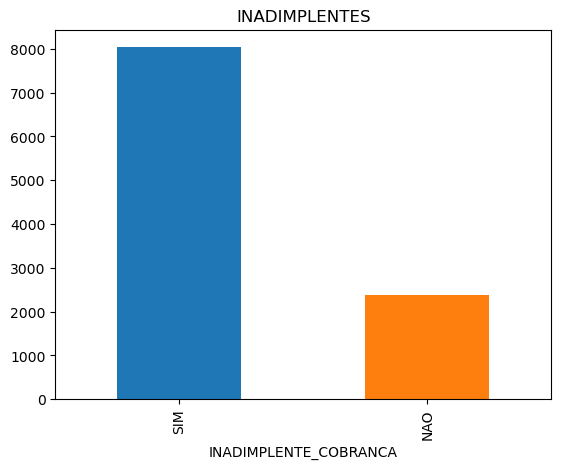

In [22]:
novo_df.INADIMPLENTE_COBRANCA.value_counts().plot(kind='bar',title='INADIMPLENTES',color=['#1F77B5', '#FF7F0E'])

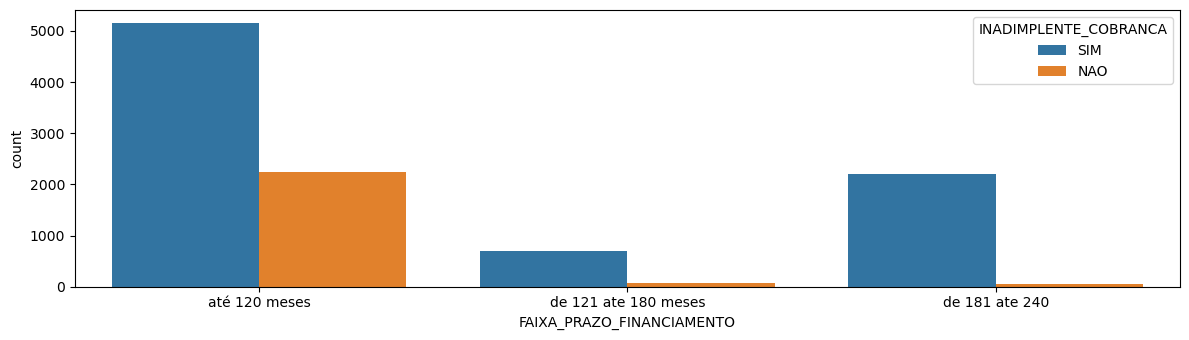

In [23]:
plt.rcParams["figure.figsize"] = [12.00, 3.50]
plt.rcParams["figure.autolayout"] = True
sns.countplot(data = novo_df, x = "FAIXA_PRAZO_FINANCIAMENTO", hue = "INADIMPLENTE_COBRANCA")
plt.show()

In [24]:
variaveis_numericas = []
for i in novo_df.columns[0:17].tolist():
    if novo_df.dtypes[i] == 'float64' or novo_df.dtypes[i] == 'int64':
        variaveis_numericas.append(i)

In [25]:
variaveis_numericas

['TAXA_AO_ANO',
 'RENDA_MENSAL_CLIENTE',
 'QT_PC_ATRASO',
 'QT_DIAS_PRIM_PC_ATRASO',
 'QT_TOTAL_PC_PAGAS',
 'VL_TOTAL_PC_PAGAS',
 'QT_PC_PAGA_EM_DIA',
 'QT_DIAS_MIN_ATRASO',
 'QT_DIAS_MAX_ATRASO',
 'QT_DIAS_MEDIA_ATRASO',
 'VALOR_PARCELA',
 'IDADE_DATA_ASSINATURA_CONTRATO']

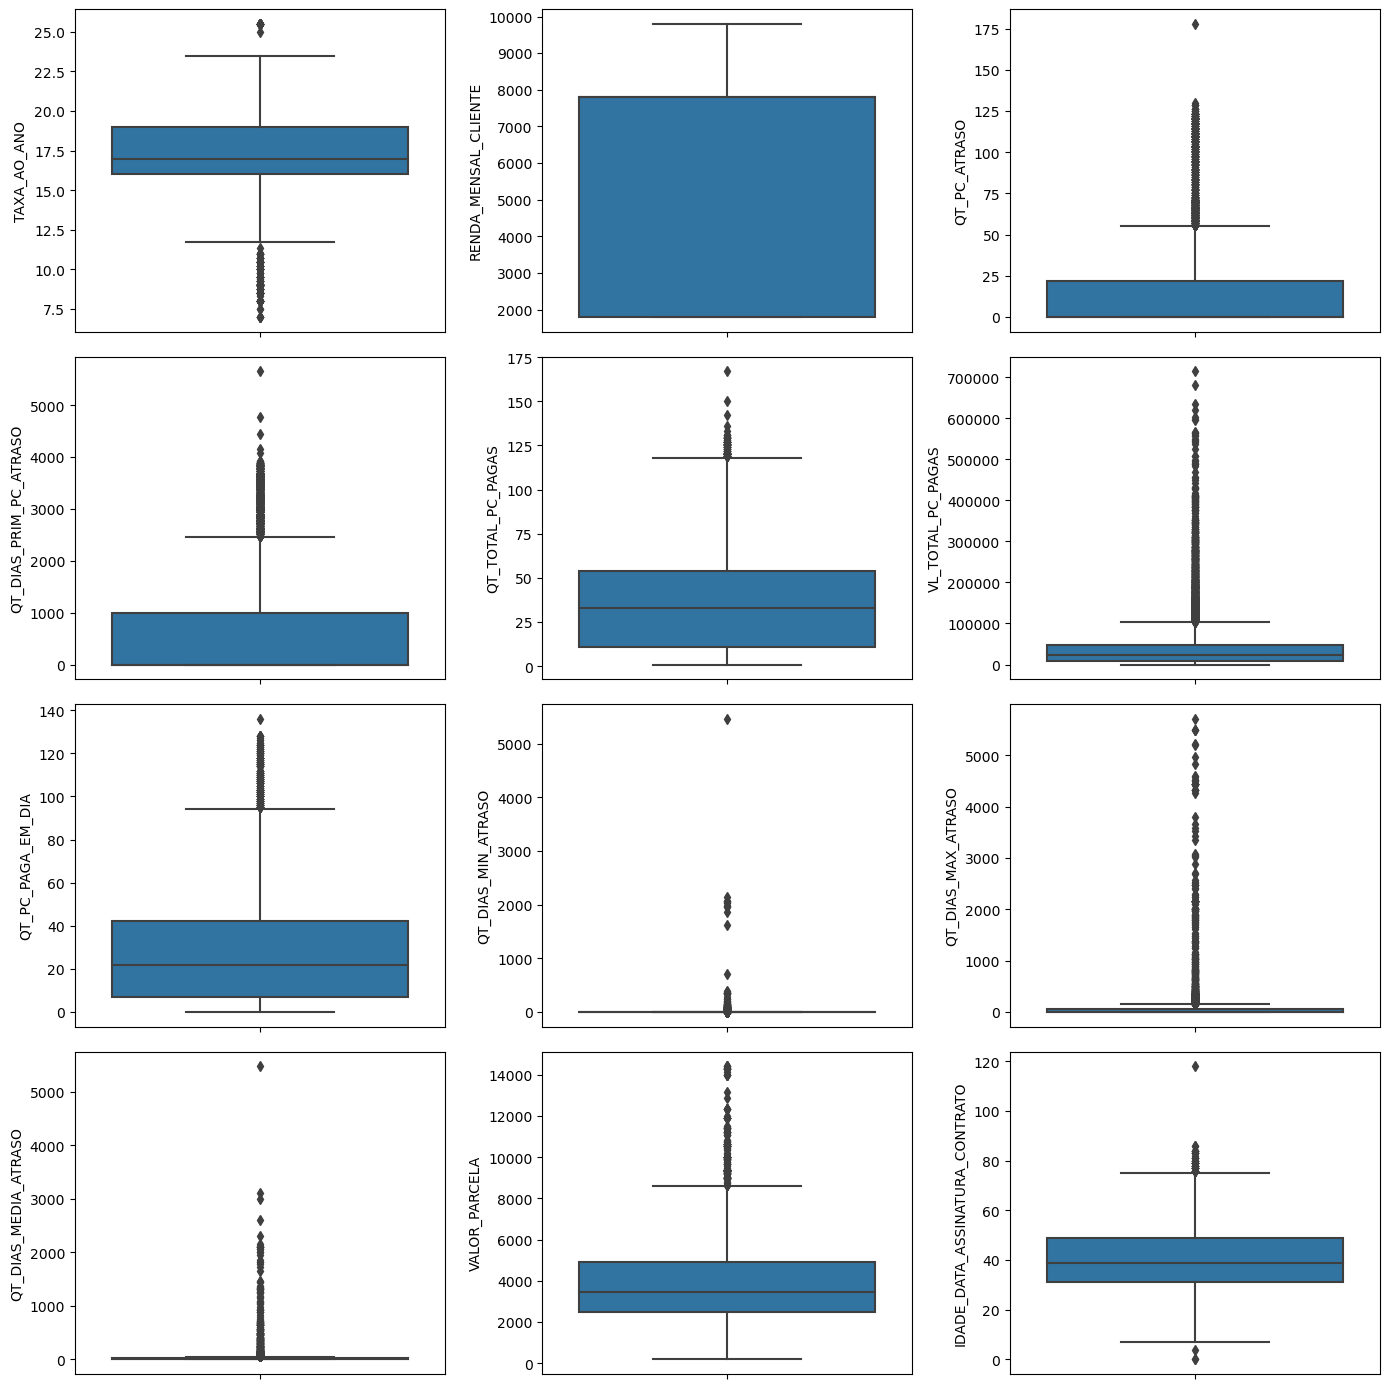

In [26]:
#Podemos observar nos boxplots abaixo que as variáveis númericas apresentam uma grande quantidade de "possíveis" outliers
#Precisamos avaliar cada uma dessas variaveis dentro do contexto dos dados para saber se realmente iremos trata-las como outlier

plt.rcParams["figure.figsize"] = [14.00, 14.00]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(4, 3) #4 linhas e 3 colunas

linha = 0
coluna = 0
for i in variaveis_numericas:
    sns.boxplot(data = novo_df, y=i, ax=axes[linha][coluna])
    coluna += 1
    if coluna == 3:
        linha += 1
        coluna = 0            

plt.show()

In [27]:
variaveis_categoricas = []
for i in novo_df.columns[0:16].tolist():
    if novo_df.dtypes[i] == 'object' or novo_df.dtypes[i] == 'category':
        variaveis_categoricas.append(i)
        
variaveis_categoricas

['CIDADE_CLIENTE',
 'ESTADO_CLIENTE',
 'FAIXA_VALOR_FINANCIAMENTO',
 'FAIXA_PRAZO_FINANCIAMENTO']

In [28]:
# criando o metodo para aplicar o 'oneHotEncoder'

lb = LabelEncoder()

for var in variaveis_categoricas:
    novo_df[var] = lb.fit_transform(novo_df[var])
    
novo_df.head()

TAXA_AO_ANO  CIDADE_CLIENTE  ESTADO_CLIENTE  RENDA_MENSAL_CLIENTE  \
0         15.0             152               5                4800.0   
1         15.0             453              25                6800.0   
2         18.0             453              25                6800.0   
3         15.0             453              25                6800.0   
4         17.0             453              25                6800.0   

   QT_PC_ATRASO  QT_DIAS_PRIM_PC_ATRASO  QT_TOTAL_PC_PAGAS  VL_TOTAL_PC_PAGAS  \
0             0                       0                 97          120078.00   
1             0                       0                103          156759.47   
2             0                       0                 98          277125.05   
3             0                       0                 87          351395.19   
4             0                       0                 71          344249.83   

   QT_PC_PAGA_EM_DIA  QT_DIAS_MIN_ATRASO  QT_DIAS_MAX_ATRASO  \
0                 72                   3                 506   
1                 42                   1                 349   
2                 83                   1                 151   
3                 66                   1                3797   
4                 57                   1                  36   

   QT_DIAS_MEDIA_ATRASO  VALOR_PARCELA  IDADE_DATA_ASSINATURA_CONTRATO  \
0                   152         471.29                            70.0   
1                    93        1858.69                            28.0   
2                    39        3123.57                            60.0   
3                   206        2873.58                            41.0   
4                    10        4224.03                            63.0   

   FAIXA_VALOR_FINANCIAMENTO  FAIXA_PRAZO_FINANCIAMENTO INADIMPLENTE_COBRANCA  
0                          0                          1                   SIM  
1                          3                          2                   SIM  
2                          5                          2                   SIM  
3                          4                          2                   SIM  
4                          5                          2                   SIM

In [29]:
#separando variaveis preditoras da variavel target(variavel principal)

preditoras = novo_df.iloc[:,0:15]
target = novo_df.iloc[:,16]

In [30]:
preditoras.head()

TAXA_AO_ANO  CIDADE_CLIENTE  ESTADO_CLIENTE  RENDA_MENSAL_CLIENTE  \
0         15.0             152               5                4800.0   
1         15.0             453              25                6800.0   
2         18.0             453              25                6800.0   
3         15.0             453              25                6800.0   
4         17.0             453              25                6800.0   

   QT_PC_ATRASO  QT_DIAS_PRIM_PC_ATRASO  QT_TOTAL_PC_PAGAS  VL_TOTAL_PC_PAGAS  \
0             0                       0                 97          120078.00   
1             0                       0                103          156759.47   
2             0                       0                 98          277125.05   
3             0                       0                 87          351395.19   
4             0                       0                 71          344249.83   

   QT_PC_PAGA_EM_DIA  QT_DIAS_MIN_ATRASO  QT_DIAS_MAX_ATRASO  \
0                 72                   3                 506   
1                 42                   1                 349   
2                 83                   1                 151   
3                 66                   1                3797   
4                 57                   1                  36   

   QT_DIAS_MEDIA_ATRASO  VALOR_PARCELA  IDADE_DATA_ASSINATURA_CONTRATO  \
0                   152         471.29                            70.0   
1                    93        1858.69                            28.0   
2                    39        3123.57                            60.0   
3                   206        2873.58                            41.0   
4                    10        4224.03                            63.0   

   FAIXA_VALOR_FINANCIAMENTO  
0                          0  
1                          3  
2                          5  
3                          4  
4                          5

In [31]:
target.head(10)

0    SIM
1    SIM
2    SIM
3    SIM
4    SIM
5    SIM
6    SIM
7    SIM
8    SIM
9    SIM
Name: INADIMPLENTE_COBRANCA, dtype: object

In [32]:
seed= 100

balanceador = SMOTE(random_state = seed) #este metodo balanceia as variaveis em desigualdade de dados, equaliza de forma que nao haja discrepancia e o modelo preditivo aprenda de forma igual ás duas variaveis

preditora_res,target_res = balanceador.fit_resample(preditoras,target)

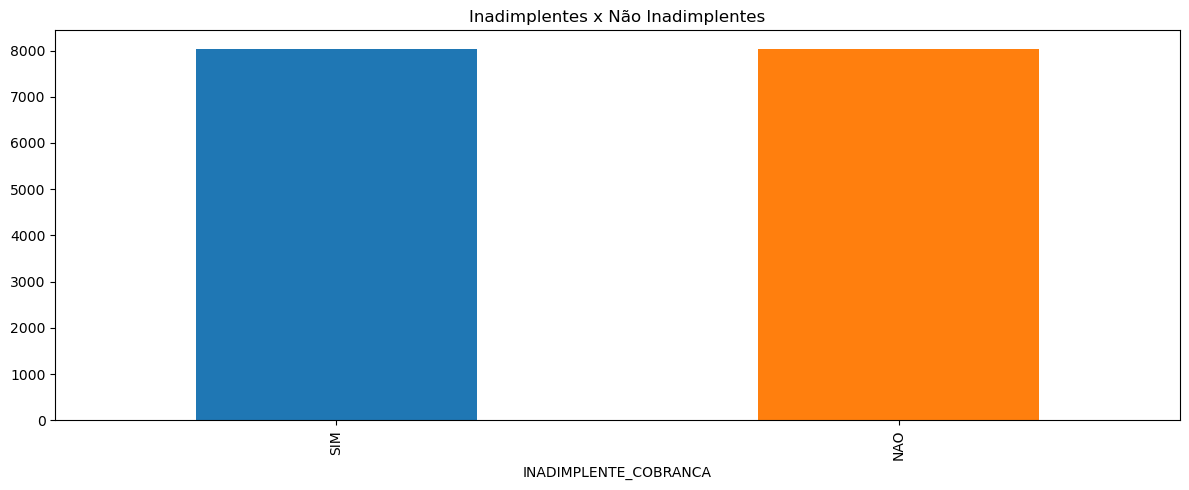

In [33]:
# Visualizando o balanceamento da variável TARGET

plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
target_res.value_counts().plot(kind='bar', title='Inadimplentes x Não Inadimplentes',color = ['#1F77B4', '#FF7F0E']);

Até aqui aprendizado do que sao variaveis preditoras e variavel target 
aprendizado em balancear as variaveis e aplicar metodo onehotEncoder para que o modelo preditivo aprenda de forma assertiva e devolva resultados confiaveis.
Com o oneHotEncoder , metodo transforma tipos de strings e tipo categoricos em tipos numericos,pois a ciencia de machine learning só interpreta dados numericos , logo para nao se perder informaçoes importantes da base de dados , este metodo faz essa transformação em dados numericos.
já o metodo SMOTE faz o balanceamento, para que o modelo que criamos tenha a mesma quantidade de dados, ele cria mais dados, com base em dados já exitentes.

In [34]:
#Divisao em dados de treino e dados de teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(preditora_res, target_res, test_size = 0.3, random_state = 42)

In [35]:
Normalizador = MinMaxScaler()
X_treino_normalizados = Normalizador.fit_transform(X_treino)
X_teste_normalizados = Normalizador.transform(X_teste)

In [36]:
X_treino_normalizados.shape

(11249, 15)

In [37]:
X_teste_normalizados.shape

(4821, 15)

In [38]:
# Criando o classificador com Random Forest
clf = RandomForestClassifier(n_estimators  = 300)

# Construção do modelo
clf = clf.fit(X_treino_normalizados, Y_treino)

In [39]:
# Verificando a acuracia do modelo com dados de teste
scores = clf.score(X_teste_normalizados,Y_teste)
scores

0.9205559012652976

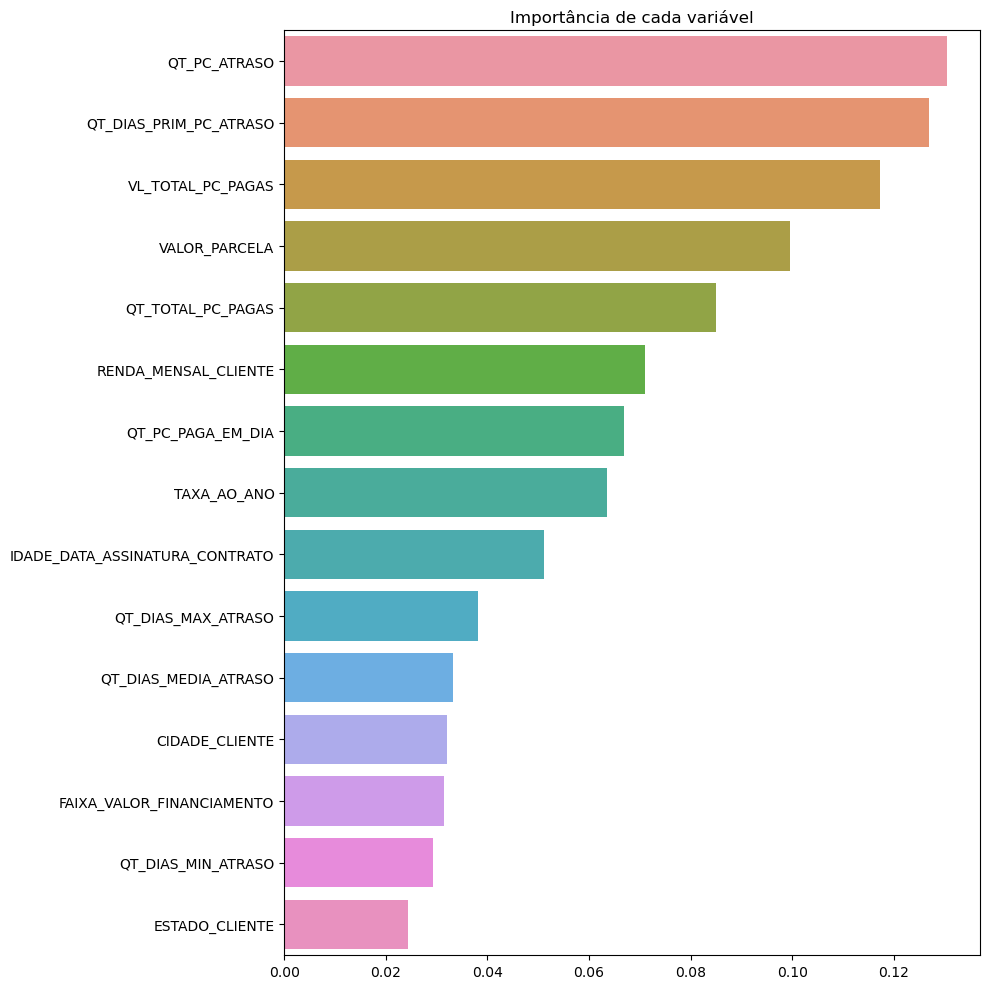

In [41]:
# Exibindo a importancia de cada variavel no modelo preditivo
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True

importances = pd.Series(data=clf.feature_importances_, index=preditoras.columns)
importances = importances.sort_values(ascending = False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada variável')
plt.show()

In [42]:
importances.sort_values(ascending = False)

QT_PC_ATRASO                      0.130417
QT_DIAS_PRIM_PC_ATRASO            0.126976
VL_TOTAL_PC_PAGAS                 0.117253
VALOR_PARCELA                     0.099551
QT_TOTAL_PC_PAGAS                 0.084947
RENDA_MENSAL_CLIENTE              0.070947
QT_PC_PAGA_EM_DIA                 0.066921
TAXA_AO_ANO                       0.063459
IDADE_DATA_ASSINATURA_CONTRATO    0.051045
QT_DIAS_MAX_ATRASO                0.038189
QT_DIAS_MEDIA_ATRASO              0.033170
CIDADE_CLIENTE                    0.032046
FAIXA_VALOR_FINANCIAMENTO         0.031480
QT_DIAS_MIN_ATRASO                0.029315
ESTADO_CLIENTE                    0.024283
dtype: float64

In [43]:
# Salvando o modelo criado e treinado
joblib.dump(clf, 'modelo_treinado.pk')

['modelo_treinado.pk']